In [1]:
import pickle
import numpy as np
import pandas as pd
import ruptures as rpt
from pathlib import Path
from scipy.io import loadmat
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from step.data import *
from step.models import *
#from step.utils import diffusion_coefficient_tmsd

from tqdm.auto import tqdm
from fastai.vision.all import *
from scipy.optimize import curve_fit

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43756\1401684556.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Defino esto aquí para que no tengas que instalar la librería
def tamsd(x, dt=1):
    "Computes the time averaged mean squared displacement of a trajectory `x`."
    return ((x[dt:] - x[:-dt])**2).sum(-1).mean()

def diffusion_coefficient_tamsd(x, t_lag=[1, 2]):
    "Estimates the diffusion coefficient fitting the `tmsd` for different `dt`."
    tamsds = [tamsd(x, dt) for dt in t_lag]
    D = np.polyfit(t_lag, tamsds, 1)[0]
    return D/2/x.shape[-1]
def inst_MSD_fit(x, D): #Roger's MSD
    y = 2*2*D*x
    return y
def MSD(x, y):
    msd = np.zeros(len(x)-1)
    for i in range(len(x)-1):
        msd[i] = sum(np.square(np.sqrt(np.square(x[i:]-x[:len(x)-i])+np.square(y[i:]-y[:len(x)-i]))))/(len(x)-i)
    return msd
def MSD_fit(x, D, a):
    y = 2*2*D*x**a
    return y
def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

In [3]:
import math
 
def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

def confinement_radius(x, nm_per_pxl=160):
    """Compute the confinement radius of a trajectory segment."""
    cov = np.cov(x)
    e_vals, _ = np.linalg.eigh(cov)
    return 2 * nm_per_pxl * np.sqrt(e_vals.mean())

Load Video

In [4]:
import mat73

In [5]:
from tkinter import Tk, filedialog

In [6]:
# Create the Tkinter root window
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [7]:
all_trajectories, all_close, all_trajectories_norm = [], [], []
for path in data_paths:
    file = mat73.loadmat(path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]
    close = file["var1"][2]
    
    # Create a list to store trajectories for the current file
    trajectories, close_log, trajs_norm = [], [], []

    # Loop through x and y data and create trajectories
    for x, y, c in zip(data_x, data_y, close):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        c = torch.tensor(c[~np.isnan(c)])
        if len(x) > 10 and len(c) > 10:  # At least > 0
            if c.mean() < 60:
                #traj = torch.stack((x - x[0], y - y[0])) #trajectories are centered to origin
                traj = torch.stack((x, y))
                displ = traj[:,1:] - traj[:,:-1]
                std = displ.std(1).unsqueeze(1)
                displ_norm = displ/std #normalization by the std of displacements
                t_norm = torch.cat((torch.zeros_like(std), (displ_norm).cumsum(1)), dim=1)
                trajs_norm.append(t_norm)  #normalized trajectories for calculation of alpha
                trajectories.append(traj)
                close_log.append(c)

    # Append trajectories of the current file to the overall list
    all_trajectories.extend(trajectories)
    all_trajectories_norm.extend(trajs_norm)
    all_close.extend(close_log)

In [8]:
model_dir = "../../models"
dim = 2

In [9]:
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets

# Diffusion coefficient
model_diff = LogXResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                         block_szs=[128, 256, 512], dropout=0., pos_enc=False,
                         n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                         linear_layers=[], norm=False, yrange=(-4.1, 2.1))
model_diff.to(default_device())

# Anomalous exponent
model_exp = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                     block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                     dim_ff=512, nhead_enc=8, linear_layers=[])
model_exp.to(default_device())

# Create the learners
learn_diff = Learner(dls, model_diff, loss_func=L1LossFlat(), model_dir=model_dir)
learn_exp = Learner(dls, model_exp, loss_func=L1LossFlat(), model_dir=model_dir)

In [10]:
# Model for Dif. coef. 
learn_diff.load(f'logxresattn_bm_2d_1_to_5_cp_varlen_42')
learn_diff.model.eval();

In [11]:
# Model for alpha
learn_exp.load(f'xresattn_exp_2d_fbm_varlen')
learn_exp.model.eval();

In [12]:
def predict(model, x):
    return to_detach(model(x.cuda().T.unsqueeze(0).float()).squeeze())

In [13]:
# Prediction
# Traj longer than 20 frames get evaluated with STEP
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
frame_rate = 0.01
pred_a, pred_d, tamsd_dif, tamsd_alpha = [], [], [], []
for traj, traj_n, c in zip(all_trajectories, all_trajectories_norm, all_close):
    #Prediction
    pred = predict(learn_exp.model, traj)
    pred_a.append(pred)
    pred = predict(learn_diff.model, traj)
    pred_d.append(pred + constant_value)
    #TAMSD
    x, y = traj[0], traj[1]
    msd = MSD(x,y)
    t = np.arange(0,int(len(msd)))
    inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
    parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
    D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
    a = parameters[1]
    tamsd_dif.append(D_tamsd)
    tamsd_alpha.append(a)

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43756\3757636107.py:20: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a


Load tiff image

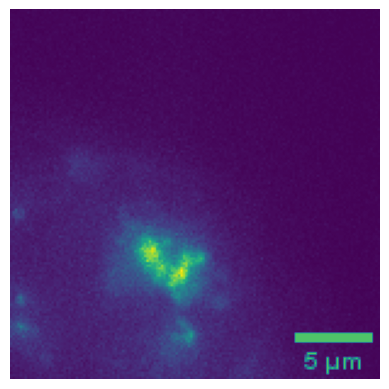

In [14]:
# Create the Tkinter root window
from PIL import Image
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select TIFF file",
    filetypes=[("TIF files", "*.tif")],
    initialdir="E:\Shares\SMB_files\Jessica",
)
# Check if a file was selected
if data_paths:
    # Load and display the image
    image = Image.open(data_paths[0])
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("No file selected")

Plot map

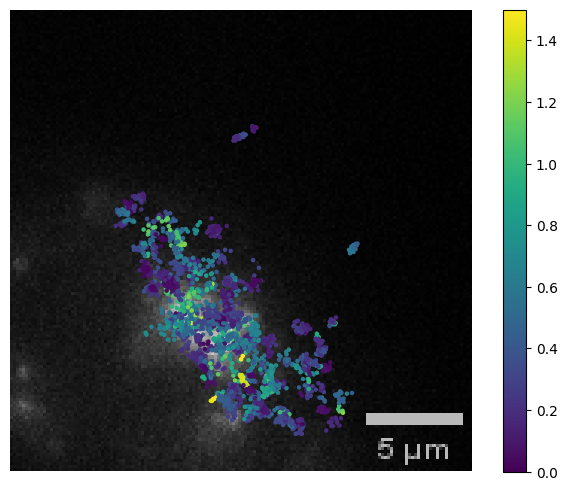

In [15]:
## Representation of alpha values in space
colors = torch.cat(pred_a).numpy()
x_coords = torch.cat([traj[1] for traj in all_trajectories]).numpy()
y_coords = torch.cat([traj[0] for traj in all_trajectories]).numpy()
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.scatter(y_coords, x_coords, c=colors, cmap='viridis', s=3, vmin=0, vmax=1.5)
plt.colorbar()

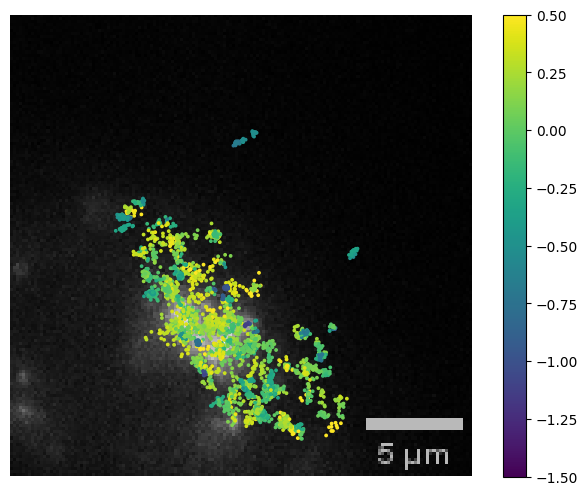

In [17]:
## Representation of diff values in space
colors = torch.cat(pred_d).numpy()
x_coords = torch.cat([traj[1][:-1] for traj in all_trajectories]).numpy()
y_coords = torch.cat([traj[0][:-1] for traj in all_trajectories]).numpy()
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.scatter(y_coords, x_coords, c=colors, cmap='viridis', s=3, vmin=-1.5, vmax=0.5)
plt.colorbar()

In [41]:
filtered_pred_d = []
filtered_pred_a = []
filtered_trajectories_x, filtered_trajectories_y = [], []

for d, a, traj in zip(pred_d, pred_a, all_trajectories):
    if torch.any(d < -1.2) and torch.any(a > 0.6):
        filtered_pred_d.append(d)
        filtered_pred_a.append(a[:-1])
        filtered_trajectories_x.append(traj[0][:-1])
        filtered_trajectories_y.append(traj[1][:-1])

In [42]:
## Representation of alpha values in space
colors = torch.cat(filtered_pred_a).numpy()
x_coords = torch.cat([traj for traj in filtered_trajectories_x]).numpy()
y_coords = torch.cat([traj for traj in filtered_trajectories_y]).numpy()
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.scatter(y_coords, x_coords, c=colors, cmap='viridis', s=5, vmin=0, vmax=1.5)
plt.colorbar()

RuntimeError: torch.cat(): expected a non-empty list of Tensors